In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

import torch
from torch import nn, Tensor
import torch.optim as optim
import torchvision

from prettytable import PrettyTable
from tqdm.notebook import tqdm
from typing import Any, Callable, List, Optional

### Install FLOWERS102 dataset

In [50]:
transforms = torchvision.transforms.Compose([
    # resize to 256x256:
    torchvision.transforms.Resize(256),
    # center crop to 224x224:
    torchvision.transforms.CenterCrop(224),
    # convert to tensor:
    torchvision.transforms.ToTensor(),
])

flowers102 = {}
flowers102['train'] = torchvision.datasets.Flowers102(root='../data', split='train', transform=transforms, download=True)
flowers102['val'] = torchvision.datasets.Flowers102(root='../data', split='train', transform=transforms, download=True)
flowers102['test'] = torchvision.datasets.Flowers102(root='../data', split='test', transform=transforms, download=True)

dataloaders = {}
for phase in ['train', 'val', 'test']:
    dataloaders[phase] = torch.utils.data.DataLoader(flowers102[phase], batch_size=8, shuffle=True, num_workers=4)

# get label names by reading them from '../data/flowers-102/oxford_flower_102_name.csv':
with open('../data/flowers-102/oxford_flower_102_name.csv') as f:
    labels = np.array([line.strip().split(',')[1] for line in f.readlines()[1:]])

In [51]:
x_batch, y_batch = next(iter(dataloaders['train']))
print(x_batch.shape, y_batch.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8])


['pelargonium' 'anthurium' 'sweet pea' 'geranium' 'blanket flower'
 'sword lily' 'morning glory' 'corn poppy']


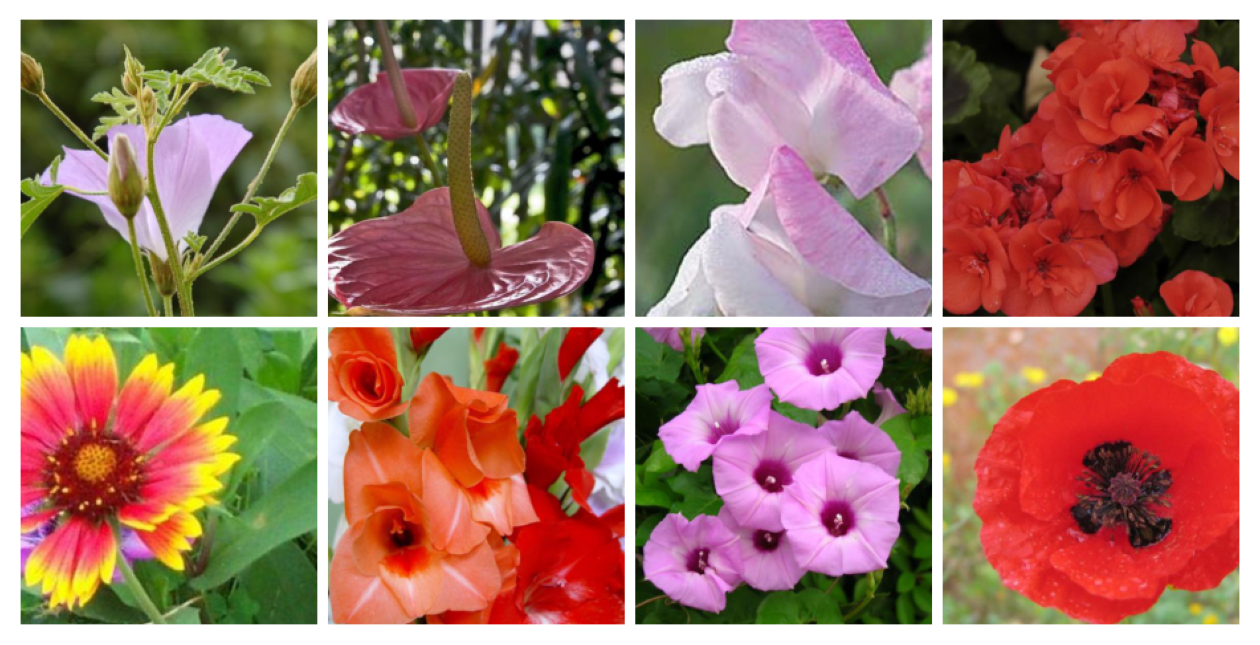

In [52]:
# show grid of images using torchvision.utils.make_grid
plt.figure(figsize=(16, 12))
plt.imshow(np.transpose(torchvision.utils.make_grid(x_batch, nrow=4, padding=8, pad_value=1).numpy(), (1, 2, 0)))
plt.axis('off')

print(labels[[y.item() for y in y_batch]])

## Standard CNN

input: `224 x 224 x 3`

output: `102 x 1`

In [9]:
CONFIG = [
    [3, 32, 3, 2, 1],  
    [32, 64, 3, 1, 1],
    [64, 128, 3, 2, 1], 
    [128, 128, 3, 1, 1], 
    [128, 256, 3, 2, 1], 
    [256, 256, 3, 1, 1], 
    [256, 512, 3, 2, 1], 
    [512, 512, 3, 1, 1], 
    [512, 512, 3, 1, 1], 
    [512, 512, 3, 1, 1], 
    [512, 512, 3, 1, 1], 
    [512, 512, 3, 1, 1], 
    [512, 1024, 3, 2, 1],
    [1024, 1024, 3, 1, 1],
]

# manually calculate number of parameters for a standard cnn network:
total_params = 0
for i, (n_in, n_out, k, s, p) in enumerate(CONFIG):
    print(f'{i}: {n_in} -> {n_out} ({k}x{k}, s={s}, p={p}), params = {n_in*n_out*k*k}')
    total_params += n_in*n_out*k*k + n_out # +n_out for bias
    total_params += 2*n_out # batchnorm2d learnable parameters:

total_params += 1024*102 + 102 # fc layer
print(f'Total number of parameters: {total_params}') # 27641190

0: 3 -> 32 (3x3, s=2, p=1), params = 864
1: 32 -> 64 (3x3, s=1, p=1), params = 18432
2: 64 -> 128 (3x3, s=2, p=1), params = 73728
3: 128 -> 128 (3x3, s=1, p=1), params = 147456
4: 128 -> 256 (3x3, s=2, p=1), params = 294912
5: 256 -> 256 (3x3, s=1, p=1), params = 589824
6: 256 -> 512 (3x3, s=2, p=1), params = 1179648
7: 512 -> 512 (3x3, s=1, p=1), params = 2359296
8: 512 -> 512 (3x3, s=1, p=1), params = 2359296
9: 512 -> 512 (3x3, s=1, p=1), params = 2359296
10: 512 -> 512 (3x3, s=1, p=1), params = 2359296
11: 512 -> 512 (3x3, s=1, p=1), params = 2359296
12: 512 -> 1024 (3x3, s=2, p=1), params = 4718592
13: 1024 -> 1024 (3x3, s=1, p=1), params = 9437184
Total number of parameters: 28379622


In [10]:
class StandardCNN(nn.Module):
    def __init__(self):
        super(StandardCNN, self).__init__()
        # input_channels, output_channels, kernel_size, stride, padding
        
        def conv(n_in, n_out, s):
            return nn.Sequential(
                nn.Conv2d(n_in, n_out, 3, s, 1),
                nn.BatchNorm2d(n_out),
                nn.ReLU(inplace=True),
            )

        self.conv = nn.Sequential(
            conv(3, 32, 2), # 224x224x3 -> 112x112x32,
            conv(32, 64, 1), # 112x112x32 -> 112x112x64
            conv(64, 128, 2), # 112x112x64 -> 56x56x128
            conv(128, 128, 1), # 56x56x128 -> 56x56x128
            conv(128, 256, 2), # 56x56x128 -> 28x28x256
            conv(256, 256, 1), # 28x28x256 -> 28x28x256
            conv(256, 512, 2), # 28x28x256 -> 14x14x512
            conv(512, 512, 1), # 14x14x512 -> 14x14x512
            conv(512, 512, 1), # 14x14x512 -> 14x14x512
            conv(512, 512, 1), # 14x14x512 -> 14x14x512
            conv(512, 512, 1), # 14x14x512 -> 14x14x512
            conv(512, 512, 1), # 14x14x512 -> 14x14x512
            conv(512, 1024, 2), # 14x14x512 -> 7x7x1024
            conv(1024, 1024, 1), # 7x7x1024 -> 7x7x1024
        )
        self.avg_pool = nn.AvgPool2d(7)
        self.predictor = nn.Linear(1024, 102)

    def _build_conv_layers(self, config):
        # build conv layers from nested dictionary:
        layers = []
        for i, (input_channels, output_channels, kernel_size, stride, padding) in enumerate(config):
            block = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
            layers.append(block)
        return nn.Sequential(*layers)
    
    def forward(self, x): 
        x = self.conv(x)               # 224x224x3 -> 7x7x1024
        print(x.shape)
        x = self.avg_pool(x).squeeze() # 7x7x1024 -> 1024
        x = self.predictor(x)          # 1024 -> 102
        return x

standard_cnn = StandardCNN()

In [45]:
# check if the model produces the expected output shape:
x_batch = torch.zeros(8, 3, 224, 224)
print(f'output dimension: {standard_cnn(x_batch).shape}')

def count_parameters(model, showTable=False):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    if showTable:
        print(table)
    return total_params

def calculate_storage(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

size_all_mb = calculate_storage(standard_cnn)
print('model size: {:.3f}MB'.format(size_all_mb)) #105.486MB

total_params = count_parameters(standard_cnn)
print(f"Total Trainable Params: {total_params}") #27641190

torch.Size([8, 1024, 7, 7])
output dimension: torch.Size([8, 102])
model size: 108.305MB
Total Trainable Params: 28379622


## MobileNetV1

Depth-wise separable filters: 
The idea is to decouple the filtering and the combination steps into two separate steps, which are normally done in one go for a usual conv layer

The `alpha` parameter controls the depth of the network

In [41]:
class MobileNetV1(nn.Module):
    def __init__(self, alpha):
        super(MobileNetV1, self).__init__()
        self.alpha = alpha

        def conv(inp, oup, stride):
            inp, oup = inp, int(oup*self.alpha)
            return nn.Sequential(
                nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        def conv_dw(inp, oup, stride):
            inp, oup = int(inp*self.alpha), int(oup*self.alpha)
            return nn.Sequential(
                nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        # input_channels, output_channels, stride
        self.conv = nn.Sequential(
            conv(3, 32, 2), # 224x224x3 -> 112x112x32,
            conv_dw(32, 64, 1), # 112x112x32 -> 112x112x64
            conv_dw(64, 128, 2), # 112x112x64 -> 56x56x128
            conv_dw(128, 128, 1), # 56x56x128 -> 56x56x128
            conv_dw(128, 256, 2), # 56x56x128 -> 28x28x256
            conv_dw(128, 256, 1), # 28x28x256 -> 28x28x256
            conv_dw(256, 512, 2), # 28x28x256 -> 14x14x512
            conv_dw(512, 512, 1), # 14x14x512 -> 14x14x512
            conv_dw(512, 512, 1), # 14x14x512 -> 14x14x512
            conv_dw(512, 512, 1), # 14x14x512 -> 14x14x512
            conv_dw(512, 512, 1), # 14x14x512 -> 14x14x512
            conv_dw(512, 512, 1), # 14x14x512 -> 14x14x512
            conv_dw(512, 1024, 2), # 14x14x512 -> 7x7x1024
            conv_dw(1024, 1024, 1), # 7x7x1024 -> 7x7x1024
        )
        self.avg_pool = nn.AvgPool2d(7)
        self.predictor = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.conv(x)  # 224x224x3 -> 7x7x1024
        x = self.avg_pool(x).squeeze()  # 7x7x1024 -> 1024
        x = self.predictor(x)  # 1024 -> 102
        return x


mobilenet_v1 = MobileNetV1(alpha=1)

In [47]:
size_all_mb = calculate_storage(standard_cnn)
print('model size: {:.3f}MB'.format(size_all_mb)) # 105.486MB

size_all_mb = calculate_storage(mobilenet_v1)
print('model size: {:.3f}MB'.format(size_all_mb)) # 12.585MB

total_params = count_parameters(standard_cnn, False)
print(f"Total Trainable Params: {total_params}") # 27641190

total_params = count_parameters(mobilenet_v1, False)
print(f"Total Trainable Params: {total_params}") # 3277382

model size: 108.305MB
model size: 12.585MB
Total Trainable Params: 28379622
Total Trainable Params: 3277382


In [21]:
mobilenet_v1

MobileNetV1(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1,

## MobileNet V2

In [117]:
class InvertedResidual(nn.Module):
    def __init__(self, inp: int, oup: int, stride: int, expand_ratio: int) -> None:
        super().__init__()

        hidden_dim = int(round(inp * expand_ratio))
        self.use_residual = inp == oup

        layers: List[nn.Module] = []

        if expand_ratio != 1:
            # pointwise expansion
            layers.append(
                nn.Sequential(
                    nn.Conv2d(inp, hidden_dim, 3, padding=1, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    nn.ReLU6(),
                )
            )

        def conv_dw(inp, oup, stride):
            # inp, oup = int(inp * self.alpha), int(oup * self.alpha)
            return nn.Sequential(
                # depth wise
                nn.Conv2d(inp, inp, 3, stride, groups=inp, padding=1, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU6(inplace=True),
                # pointwise
                nn.Conv2d(inp, oup, 1, 1, padding=0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU6(inplace=True),
            )

        # depth-wise convolution:
        layers.append(conv_dw(hidden_dim, oup, stride))
        self.conv = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [118]:
class MobileNetV2(nn.Module):
    def __init__(self, alpha: float) -> None:
        super().__init__()

        config = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # create list of features and add first layer
        features: List[nn.Module] = [nn.Conv2d(3, 32, 3, 2, 1, bias=False)]

        # bottleneck layers
        input_channels = 32 
        for t, c, n, s in config:
            for i in range(n):
                s = s if i == 0 else 1
                features.append(InvertedResidual(input_channels, c, s, t))
                input_channels = c

        # append last conv2d
        features.append(nn.Conv2d(c, 1280, 1, 1, bias=False))

        self.features = nn.Sequential(*features)

        self.avg_pool = nn.AvgPool2d(7)
        self.predictor = nn.Linear(1280, 102)

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        print(x.shape)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.predictor(x)
        return x

mobilenet_v2 = MobileNetV2(alpha=1)

In [119]:
# check if the model produces the expected output shape:
x_batch = torch.zeros(8, 3, 224, 224)
print(f'output dimension: {mobilenet_v2(x_batch).shape}')

size_all_mb = calculate_storage(mobilenet_v2)
print('model size: {:.3f} MB'.format(size_all_mb)) # 32.038MB

total_params = count_parameters(mobilenet_v2, False)
print(f"Total Trainable Params: {total_params}") # 8366886

torch.Size([8, 1280, 7, 7])
output dimension: torch.Size([8, 102])
model size: 32.038MB
Total Trainable Params: 8366886
